# Goals of this page :

    # Baseline : A Deep Learning-based Cryptocurrency Price Prediction Scheme for Financial Institutions
    # In keras redesign the model with ( 1 hr ) data points and compare the results we get.
    # Duplicated the model from baseline although couldnt train as took too long.\
    # Created first TCN - v.minimal 
    
    -- TO Do --
    # Once we have duplicated model in the baseline article , we can then experiment :
        # Add more LSTM layers.
        # Try multi-variate.
        # TCN instead of LSTM Layers.

In [1]:
# Pulling BTC , XRP , ETH (1 hour) data 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models

In [3]:
df_btc = pd.read_csv("../../../cryptoData/BTC_1h_data.csv")
df_xrp = pd.read_csv("../../../cryptoData/XRP_1h_data.csv")
df_eth = pd.read_csv("../../../cryptoData/ETH_1h_data.csv")

In [4]:
df_btc

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,43492.63,43569.67,43233.67,43443.77,1305.626920
39217,2022-02-11 11:00:00,43443.78,43523.42,43320.00,43357.53,744.524180
39218,2022-02-11 12:00:00,43357.53,43700.78,43253.31,43570.77,1317.546940
39219,2022-02-11 13:00:00,43570.77,43826.00,43503.01,43765.14,1564.251800


In [5]:
df_headers = df_btc.columns

In [6]:
# Removing everything but the closing price
btc_data = df_btc.values[:, 4 ,].astype(float)
eth_data = df_eth.values[:, 4 ,].astype(float)
xrp_data = df_xrp.values[:, 4 ,].astype(float)

len(btc_data)

39221

In [7]:
# Splitting off training , validation ,  test sets , 70% , 20% , 10%

def splitting_train_test(data , percTrain , percVal):
    onePercent = len(data) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[:numberTraining]
    validationData = data[numberTraining : numberTraining + numberValidation]
    testData = data[numberTraining + numberValidation:] 
    
    return trainingData.reshape(-1,1) , validationData.reshape(-1,1) , testData.reshape(-1,1)

In [8]:
#Reshaping the data so we can use min-max a
btc_train , btc_val ,  btc_test = splitting_train_test(btc_data , 70 , 20 )
eth_train , eth_val , eth_test = splitting_train_test(eth_data , 70 , 20 )
xrp_train , xrp_val , xrp_test = splitting_train_test(xrp_data , 70 , 20 )

(btc_train.shape , btc_val.shape , btc_test.shape)

((27440, 1), (7840, 1), (3941, 1))

In [9]:
def scaling_data(train , validation , test):

    scaler = MinMaxScaler()
    scaler.fit(train)
    
    return scaler.transform(train) , scaler.transform(validation) , scaler.transform(test)

In [10]:
# Scaling the data after we split to avoid leakage, transforming validation and test from training set for the same reason.

scaled_train_btc , scaled_val_btc , scaled_test_btc = scaling_data(btc_train , btc_val , btc_test)
scaled_train_eth , scaled_val_eth , scaled_test_eth = scaling_data(eth_train , eth_val , eth_test)
scaled_train_xrp , scaled_val_xrp , scaled_test_xrp = scaling_data(xrp_train , xrp_val , xrp_test) 

In [11]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [12]:
window_length = 24
features = 1

sliding_winda_train = sliding_window(scaled_train_btc , window_length)
sliding_winda_val = sliding_window(scaled_val_btc, window_length)

In [13]:
data , targets = sliding_winda_train
validation_data = sliding_winda_val

<Strong> Here I am testing using a standard split.<Strong>

<Strong> Creating the Hybrid Model. Dense Layer 16 </Strong>

In [15]:
inputs = Input(shape = (window_length , features) )

#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , return_sequences = True)(inputs)
x = Dropout(0.2)(x) 
x = LSTM(50)(x)
x = Dropout(0.2)(x) 
x = Dense(16)(x)

y = GRU(30 , input_shape=(window_length , features))(inputs)
y = Dropout(0.5)(y)
y = Dense(16)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 24, 30)       3840        ['input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 24, 30)       0           ['lstm_2[0][0]']                 
                                                                                                  
 lstm_3 (LSTM)                  (None, 50)           16200       ['dropout_3[0][0]']              
                                                                                            

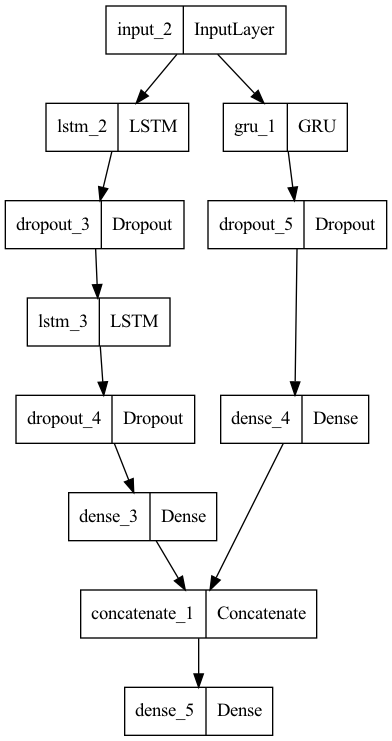

In [16]:
model.summary()
plot_model(model)

In [17]:
#If use validation in this part , then leakage as we are using the normalized values of the training set which in this case would include validation set.
#Validation set needs to be in a tuple with x , y

model.compile(optimizer='adam' , loss = 'mse')

model.fit(data , targets , validation_data = validation_data  , batch_size = 512  , epochs =100 , verbose = 1 )

Epoch 1/100
54/54 [==============================] - 11s 121ms/step - loss: 0.0089 - val_loss: 0.0662
Epoch 2/100
54/54 [==============================] - 6s 106ms/step - loss: 0.0016 - val_loss: 0.1349
Epoch 3/100
34/54 [=================>............] - ETA: 1s - loss: 0.0011

KeyboardInterrupt: 

<Strong> Temporal Neural Network </Strong>

<Strong> Padding="causal" ( pads the layer's input with zeros in the front so that we can also predict the values of early time steps in the frame ) </Strong>

In [ ]:
# Full Converage = 1 + (kernel_size-1) . dilation_base^n - 1 / dilation_base - 1 >= l
# Number of required layers = log (dilation_base) ( ((input_length - 1) . (dilation_base - 1) / (k - 1) ) + 1 )
# Padding for each layer dilation_base ^ layers below our current . (kernel_size - 1) below = input

# For full coverage we need 4 layers (we are using a base of 2)


model = models.Sequential()

# Casual adds padding to the start of input sequence
model.add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))

model.add(Conv1D(filters=4, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=2))

# For full coverage we need 4 layers 
model.add(Conv1D(filters=4, kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=4))

# For full coverage we need 4 layers 
model.add(Conv1D(filters=4, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate= 8))


model.summary()